In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import wfdb
from wfdb import processing

In [2]:
def parabola(a,n,r):
    assert n>2*r
    y = np.zeros(n, dtype = np.float32)
    x = np.array(range(2, 2 * r+1))
    for i in a:
        if i > r-1 and i <= n-r:
            # y[i-r-1:i+r+1] = ((r+1)**2-(x-r-1)**2)/(r+1)**2
            y[i-r+1:i+r] = ((r+1)**2-(x-r-1)**2)/(r+1)**2
        elif i < r:
            y[:i+r] = ((r+1)**2-(x[r-i-1:]-r-1)**2)/(r+1)**2
        elif i<n:
            y[i-r+1:] = ((r+1)**2-(x[:r-1+(n-i)]-r-1)**2)/(r+1)**2
    return y

In [3]:
def selectFromSignal(signal, seqL, ninputs, numChan=2):
    """ 
    seqL:  number of timesteps to be used in recurrent nn
    ninput : is number of inputs in each timestep
    """
    segmentL  = seqL * ninputs; print(segmentL)
    inpOutSegment = tf.random_crop(signal, [numChan, segmentL])
    inputs = inpOutSegment[0, :]
    target = inpOutSegment[1, :]
    return inputs, target

def selectFromSignals(signals, seqL, ninputs, numChan=3):
    file_idx = np.random.randint(0, signals.shape[0]) 
#     signal = signals[file_idx, :, :]
    
    segmentL  = seqL * ninputs
    inpOutSegment = tf.random_crop(signals[file_idx, :, :], [numChan, segmentL])
#   inpOutSegment = tf.random_crop(signals[file_idx, :, 100:], [numChan, segmentL])

    inputs = inpOutSegment[0:2, :]
    target = inpOutSegment[2, :]
    return inputs, target


((462600,), (462600,))

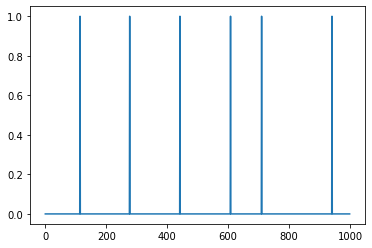

In [26]:
record = wfdb.rdrecord('train/I01', channels=[1, 6])
annotation = wfdb.rdann('train/I01', 'atr')

signals = record.__dict__['p_signal']
channel_ii = signals[:, 0]
channel_v1 = signals[:, 1]

ticks = annotation.__dict__['sample']
symbols = annotation.__dict__['symbol']

ticks_signal = np.zeros(channel_ii.shape)
ticks_signal[ticks] = 1.0
plt.plot(ticks_signal[:1000])

channel_ii.shape, channel_v1.shape

### Preprocessing functions

In [27]:
def removeBaseline(signal,fs):
    baseline = np.convolve(signal, np.ones(fs)/fs, mode = 'same')
    signalFinal = signal-baseline
    return signalFinal,baseline

def getTwoNormalizedChannels(signals, fs):
    
    # get channel II and V1
    channel_ii = signals[:, 0]
    channel_v1 = signals[:, 1]
    
    # remove baselines
    chii_data_filter, _ = removeBaseline(channel_ii, fs)
    chv1_data_filter, _ = removeBaseline(channel_v1, fs)
    
    # reshape to  -> (1, 462600)
    chii_data_filter = chii_data_filter.reshape((1, -1))
    chv1_data_filter = chv1_data_filter.reshape((1, -1))
    
    # put two signals together -> (2, 462600)
    signal = np.concatenate((chii_data_filter, chv1_data_filter), axis=0)
    
    return signal

### Parameters

In [75]:
window_size = 240
p_param = 7
seqL = 20
fs = 257
ninputs = int(0.05*fs) 
batchSize = 8
testDataSize = 62600
val_perc = 0.15

### Load Training data into all_data

In [76]:
record = wfdb.rdrecord('train/I01', channels=[1, 6])
annotation = wfdb.rdann('train/I01', 'atr')
signals = record.__dict__['p_signal']

N = signals.shape[0]
train_fs = record.__dict__['fs']
print(">>> Training data fs is {}\n".format(int(train_fs)))

import os
filenames = np.unique(list(map(lambda x : x.split('.')[0], os.listdir('train'))))
qrsAnnot = ['N','L','R','B','A','a','J','S','V','r','F','e','j','n','E','/','f','Q',' ?']

all_data = np.zeros((len(filenames), signals.shape[1]+1, N), dtype=np.float32)
idx = 0

for f in filenames[:5]:
    path = 'train/{}'.format(f)
    # read annotation
    annotation = wfdb.rdann(path, 'atr')
    uniq_symbols = np.unique(annotation.__dict__['symbol'])
    
    # check if all symbols can be found in qrsAnnot list
    if not np.all([(symbol in qrsAnnot) for symbol in uniq_symbols]):
        print("! Skipping {}...".format(f))
        continue
    
    # read signals
    record = wfdb.rdrecord(path, channels=[1, 6])
    signals = record.__dict__['p_signal']
    signal = getTwoNormalizedChannels(signals, train_fs)

    # get ticks and create parabola
    ticks = annotation.__dict__['sample']
    if np.any(ticks < 0):
        print("! Negative ticks in ", f)
        ticks = ticks[1:]
    
    p = parabola(ticks, N, p_param)
    
    targets = p.reshape((1, -1))
    
    # create data with signals on data[0], data[1] and ticks on data[2]
    data = np.concatenate((signal, targets), axis=0)
    
    all_data[idx] = data
    idx += 1
    print("Loaded ", f)

all_data = all_data[:idx]
print("\nTraining data shape:", all_data.shape)

>>> Training data fs is 257

Loaded  I01
Loaded  I02
Loaded  I03
! Negative ticks in  I04
Loaded  I04
Loaded  I05

Training data shape: (5, 3, 462600)


### Load Test data into test_data

In [77]:
record = wfdb.rdrecord('test/100')
annotation = wfdb.rdann('test/100', 'atr')
signals = record.__dict__['p_signal']
test_fs = record.__dict__['fs']
print(">>> Test data fs is {}\n".format(int(test_fs)))

signals, annotation = processing.resample_multichan(signals, annotation, 
                                                            test_fs, train_fs)
N = signals.shape[0]

import os
filenames = np.unique(list(map(lambda x : x.split('.')[0], os.listdir('test'))))
qrsAnnot = ['N','L','R','B','A','a','J','S','V','r','F','e','j','n','E','/','f','Q',' ?']

test_data = np.zeros((len(filenames), signals.shape[1]+1, N), dtype=np.float32)
idx = 0

for f in filenames[:5]:
    path = 'test/{}'.format(f)
    # read annotation
    annotation = wfdb.rdann(path, 'atr')
    uniq_symbols = np.unique(annotation.__dict__['symbol'])
    
    # check if all symbols can be found in qrsAnnot list
    # ... skipped?
    
    # read signals
    record = wfdb.rdrecord(path)
    signals = record.__dict__['p_signal']
    
    # resample to train frequency!
    new_signals, new_annotation = processing.resample_multichan(signals, annotation, 
                                                            test_fs, train_fs)
    
    signal = getTwoNormalizedChannels(new_signals, test_fs)
    # get ticks and create parabola
    ticks = new_annotation.__dict__['sample']

    if np.any(ticks < 0):
        print("! Negative ticks in ", f)
        ticks = ticks[1:]
    
    p = parabola(ticks, N, p_param)
    
    targets = p.reshape((1, -1))

    # create data with signals on data[0], data[1] and ticks on data[2]
    data = np.concatenate((signal, targets), axis=0)
    
    test_data[idx] = data
    idx += 1
    print("Loaded ", f)

test_data = test_data[:idx]
print("\nTest data shape: ", test_data.shape)

>>> Test data fs is 360

Loaded  100
Loaded  101
Loaded  102
Loaded  103
Loaded  104

Test data shape:  (5, 3, 464027)


### Preview of processed data

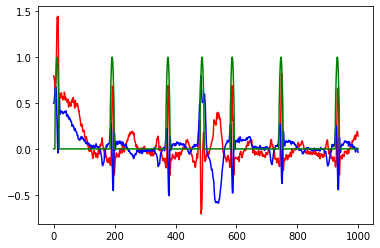

In [78]:
sig = all_data[1, :, :]
x = np.arange(sig.shape[1])

plt.plot(x[:1000], sig[0, :1000], 'r', x[:1000], sig[1, :1000], 'b', x[:1000], sig[2, :1000], 'g')

### Parameters

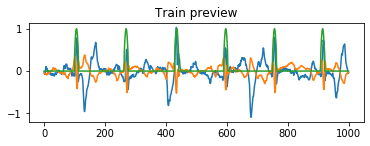

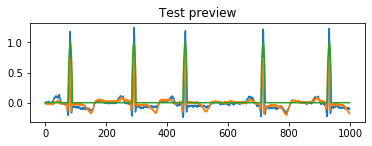

In [79]:
train_sample = all_data[0, :, 1000:2000]
x = np.arange(1000)

plt.figure(1)
plt.subplot(211)

plt.plot(x, train_sample[0, :], x, train_sample[1, :], x, train_sample[2, :])
plt.title("Train preview")
plt.show()

test_sample = test_data[0, :, 1000:2000]

plt.subplot(212)

plt.plot(x, test_sample[0, :], x, test_sample[1, :], x, test_sample[2, :])
plt.title("Test preview")
plt.show()

### Prepare Datasets for feed forward neural network

In [80]:
trainData = all_data
testData = test_data

# train validation split
valData = trainData[:, :, :int(trainData.shape[2]*val_perc)]
trainData = trainData[:, :, int(trainData.shape[2]*val_perc):]

print(trainData.shape, valData.shape, testData.shape)

# training data
trainData = tf.data.Dataset.from_tensors(trainData)
trainData = trainData.map(lambda x:  selectFromSignals(x, seqL, ninputs))
trainData = trainData.repeat()  # Repeat the input indefinitely.
trainData = trainData.batch(batchSize)

# validation data
valData = tf.data.Dataset.from_tensors(valData)
valData = valData.map(lambda x:  selectFromSignals(x, seqL, ninputs))
valData = valData.repeat()  # Repeat the input indefinitely.
valData = valData.batch(batchSize)

# test data
testData = tf.data.Dataset.from_tensors(testData)
testData = testData.map(lambda x:  selectFromSignals(x, seqL, ninputs))
testData = testData.repeat()  # Repeat the input indefinitely.
testData = testData.batch(batchSize)


(5, 3, 393210) (5, 3, 69390) (5, 3, 464027)


### Train data samples preview

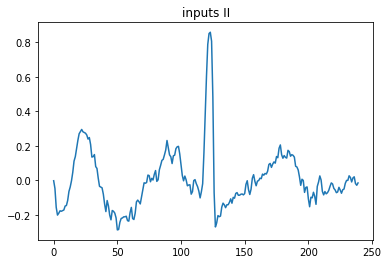

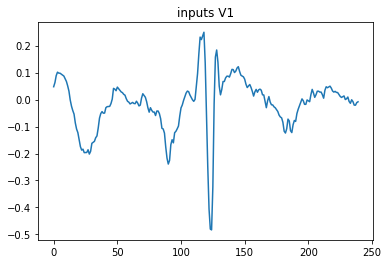

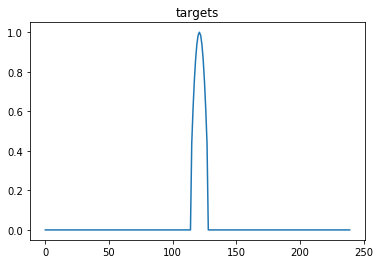

In [81]:
# let's visualize the model's input data and target data
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
    
plt.plot(inp[0,0,:])
plt.title('inputs II')
plt.show()
plt.plot(inp[0,1,:])
plt.title('inputs V1')
plt.show()
plt.plot(targ[0,:])
plt.title('targets')
plt.show()

### Build and train feed forward model

In [82]:
from tensorflow.python.keras import layers

ffwdModel = tf.keras.Sequential()
ffwdModel.add(layers.Dense(64, activation='relu', input_shape=(2,seqL*ninputs)))
ffwdModel.add(layers.Dense(64, activation='relu'))
ffwdModel.add(layers.Flatten())
ffwdModel.add(layers.Dense(seqL * ninputs))
ffwdModel.summary()

ffwdModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
ffwdModel.fit(trainData, epochs=5, steps_per_epoch=1000, validation_data=valData, validation_steps=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2, 64)             15424     
_________________________________________________________________
dense_1 (Dense)              (None, 2, 64)             4160      
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 240)               30960     
Total params: 50,544
Trainable params: 50,544
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1000/1000 [==============================] - 15s 15ms/step - loss: 0.0375 - mean_absolute_error: 0.1085 - val_loss: 0.0168 - val_mean_absolute_error: 0.0825
Epoch 2

### Evaluate on the test set and preview sample prediction

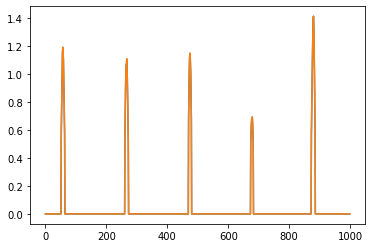

In [176]:
super_p = prediction.reshape(-1)
new_p = super_p
new_p[new_p < 0.5] = 0.0
plt.plot(np.arange(1000), super_p[:1000], np.arange(1000), new_p[:1000])

In [179]:
processing.compare_annotations??

242/242 [==============================] - 1s 6ms/step - loss: 0.0217 - mean_absolute_error: 0.0972
(463920,)
12 reference annotations, 12 test annotations

True Positives (matched samples): 11
False Positives (unmatched test samples: 1
False Negatives (unmatched reference samples): 1

Specificity: 0.9167 (11/12)
Positive Predictivity: 0.9167 (11/12)
False Positive Rate: 0.0833 (1/12)


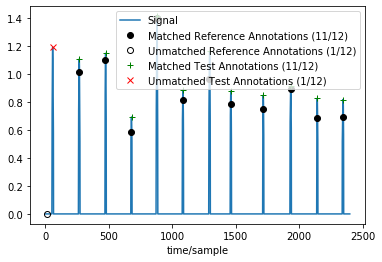

In [190]:
def getNextFragment(data, fsize):
    
    numSteps = int(np.floor(data.shape[1] / fsize))
    for i in range(numSteps):
        fragment = data[:, i*fsize : (i+1)*fsize]
        inputs = fragment[0:2, :]
        target = fragment[2, :]
        yield inputs, target
  
def padEnds(signals, batchSize, seqL, ninputs):
    n = signals.shape[1]
    batchWindowSize = batchSize * seqL * ninputs
    batches_n = int(np.ceil(n / batchWindowSize))

    new_signals = np.pad(signals, ((0,0), (0, batchWindowSize - n % batchWindowSize)), mode='constant', constant_values=(0.0))
    return new_signals, int(new_signals.shape[1] / batchWindowSize)

file = test_data[0, :]
new_f, num_steps = padEnds(file, batchSize, seqL, ninputs)
test = tf.data.Dataset.from_generator(lambda : getNextFragment(file, seqL*ninputs),
                                           (tf.float32, tf.float32),
                                           (tf.TensorShape([2, seqL*ninputs]),
                                            tf.TensorShape([seqL*ninputs,])))
batchSize = 8
test = test.batch(batchSize)

out = ffwdModel.evaluate(test, steps=num_steps)
prediction = ffwdModel.predict(test, steps=num_steps)

prediction = prediction.reshape(-1)
prediction[prediction < 0.5] = 0.0

print(prediction.shape)

# targ_in =  processing.find_local_peaks(sig=np.concatenate(new_f[2, :]), radius=30)

targ_in =  processing.find_local_peaks(sig=new_f[2, :2400], radius=150)
out_peaks = processing.find_local_peaks(sig=prediction[:2400], radius=150)
signal_input_channel_ii = new_f[0,:1200]

comparitor = processing.compare_annotations(targ_in, out_peaks, int(0.1*seqL*ninputs), prediction[:2400])
comparitor.print_summary()
comparitor.plot()


500/500 [==============================] - 7s 14ms/step - loss: 0.0319 - mean_absolute_error: 0.1106
test mean square error (loss):  0.03190245003253221   test absolute error:  0.110564515


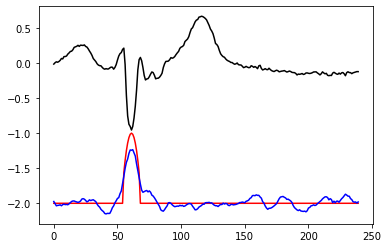

In [83]:
out = ffwdModel.evaluate(testData, steps=500)
print('test mean square error (loss): ', out[0], '  test absolute error: ', out[1])
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
output = ffwdModel.predict(inp)
t = range(seqL*ninputs)
plt.plot(t,inp[0,0,:],'k',t,targ[0]-2,'r',t,output[0]-2,'b')
plt.show()

In [17]:
def selectFromSignals_LSTM(signals, seqL, ninputs, numChan=3):
    file_idx = np.random.randint(0, signals.shape[0]) 
    signal = signals[file_idx, :, :]
    
    segmentL  = seqL * ninputs
    inpOutSegment = tf.random_crop(signal, [numChan, segmentL])

    inputs = inpOutSegment[0:2, :]
    target = inpOutSegment[2, :]
    
    inputs = tf.transpose(inputs)
    inputs = tf.reshape(inputs, (seqL, ninputs*2))
#     inputs = tf.transpose(inputs, perm=[0,2,1])
    
    print(inputs.shape, target.shape)
    return inputs, target

In [18]:
trainData = all_data
testData = test_data

# train validation split
valData = trainData[:, :, :int(trainData.shape[2]*val_perc)]
trainData = trainData[:, :, int(trainData.shape[2]*val_perc):]

# print(trainData.shape, valData.shape, testData.shape)

# training data
trainData = tf.data.Dataset.from_tensors(trainData)
trainData = trainData.map(lambda x:  selectFromSignals_LSTM(x, seqL, ninputs))
trainData = trainData.repeat()  # Repeat the input indefinitely.
trainData = trainData.batch(batchSize)

# validation data
valData = tf.data.Dataset.from_tensors(valData)
valData = valData.map(lambda x:  selectFromSignals_LSTM(x, seqL, ninputs))
valData = valData.repeat()  # Repeat the input indefinitely.
valData = valData.batch(batchSize)

# test data
testData = tf.data.Dataset.from_tensors(testData)
testData = testData.map(lambda x:  selectFromSignals_LSTM(x, seqL, ninputs))
testData = testData.repeat()  # Repeat the input indefinitely.
testData = testData.batch(batchSize)

(20, 24) (240,)
(20, 24) (240,)
(20, 24) (240,)


In [19]:
numLstmUnits = 32
denseDim = ninputs
ffwdModelSequential = tf.keras.Sequential()

# ffwdModelSequential.add(layers.Reshape((seqL,ninputs), input_shape=(seqL*ninputs,)))

ffwdModelSequential.add(layers.LSTM(32, input_shape=(seqL, ninputs*2), return_sequences=True)) 
ffwdModelSequential.add(layers.TimeDistributed(layers.Dense(denseDim)))
ffwdModelSequential.add(layers.Reshape((seqL*ninputs,)))

# ffwdModelSequential.add(layers.LSTM(units=numLstmUnits, return_sequences=True))
# ffwdModelSequential.add(layers.LSTM(units=numLstmUnits, return_sequences=False))

# ffwdModelSequential.add(layers.Dense(denseDim))
# ffwdModelSequential.add(layers.Dense(seqL*ninputs))

# ffwdModelSequential.add(layers.TimeDistributed(layers.Dense(denseDim)))

# ffwdModelSequential.add(layers.Reshape((seqL*ninputs)))

ffwdModelSequential.summary()

ffwdModelSequential.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
ffwdModelSequential.fit(trainData,  epochs=5, steps_per_epoch=1000, validation_data=valData, validation_steps=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 32)            7296      
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 12)            396       
_________________________________________________________________
reshape (Reshape)            (None, 240)               0         
Total params: 7,692
Trainable params: 7,692
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0280 - mean_absolute_error: 0.0862 - val_loss: 0.0057 - val_mean_absolute_error: 0.0403
Epoch 2/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.0065 - mean_absolute_error: 0.0410 - val_loss: 0.0041 - val_mean_absolute_error: 0.0307
Epoch 3/10
1000/1000 [==============================] - 32s 32ms/ste

In [21]:
ffwdModelSequential.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
out = ffwdModelSequential.evaluate(testData, steps=500)
print('test mean square error (loss): ', out[0], '  test absolute error: ', out[1])

500/500 [==============================] - 2s 5ms/step - loss: 0.0232 - mean_absolute_error: 0.0643
test mean square error (loss):  0.02322170526627451   test absolute error:  0.06427042


(8, 240, 2)
(8, 240, 2)


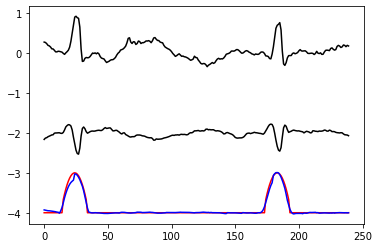

In [30]:
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
output = ffwdModelSequential.predict(inp)
t = range(seqL*ninputs)
print(inp.shape)
inp = inp.reshape(8, -1, 2)
print(inp.shape)
plt.plot(t,inp[0,:,0],'k',t,inp[0,:,1]-2,'k', t,targ[0]-4,'r',t,output[0]-4,'b')
plt.show()